# Run Pharaglow 

In [42]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
# image io and analysis
import json
import pims
import trackpy as tp

# plotting
import matplotlib  as mpl 
import matplotlib.pyplot as plt 

#our packages
from pharaglow import tracking, run, features, util

### Load data and create binary masks 

In [43]:
%%time
# io
path = "/media/scholz_la/hd2/Nicolina/Nicolina/"
movie = "20200319_NZ0040"
fname = os.path.join(path,movie,"*.tiff")
parameterfile = "/home/scholz_la/Desktop/pumping/PharaGlow/pharaglow_parameters_mks.txt"
outfile = os.path.join(path,movie+"_{}_{}.json")
print(outfile)
lawnfile ='/media/scholz_la/hd2/Nicolina/Nicolina/Lawns/NZ0040_lawn.bmp'

print('Starting pharaglow analysis...')
rawframes = pims.open(fname)
rawframes = rawframes[:500]

print('Loading parameters from {}'.format(parameterfile.split('/')[-2:]))
with open(parameterfile) as f:
    param = json.load(f)

if lawnfile is not None:
    print('open and binarize lawn file')
    lawn = pims.open(lawnfile)[0]
    binLawn = features.findLawn(lawn)
    

/media/scholz_la/hd2/Nicolina/Nicolina/20200319_NZ0040_{}_{}.json
Starting pharaglow analysis...
Loading parameters from ['PharaGlow', 'pharaglow_parameters_mks.txt']
open and binarize lawn file
CPU times: user 9.02 s, sys: 735 ms, total: 9.75 s
Wall time: 1.38 s


### Improve lawn detection if neccessary

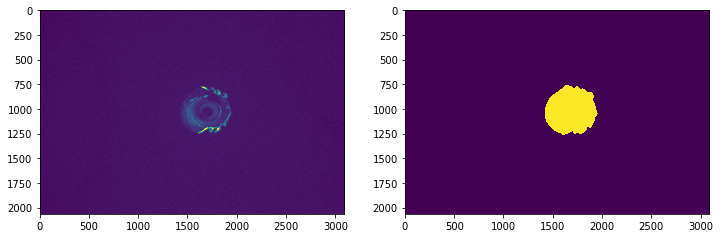

In [44]:
from skimage.filters import threshold_li, gaussian, threshold_yen, threshold_otsu
from skimage.morphology import skeletonize, watershed, disk, remove_small_holes, remove_small_objects
image = gaussian(lawn, 5, preserve_range = True)
thresh = threshold_li(image)
binary = image > thresh*0.8
binary = remove_small_holes(binary, area_threshold=15000, connectivity=1, in_place=False)
binary = remove_small_objects(binary, min_size=50000, connectivity=8, in_place=False)
binLawn = binary
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(lawn)
plt.subplot(122)
plt.imshow(binLawn)

In [45]:
%%time
# detecting objects
print('Binarizing images')
masks = tracking.calculateMask(rawframes, minSize = param['minSize'], bgWindow = param['bgWindow']
                               , thresholdWindow = param['thresholdWindow'], smooth =  param['smooth'],
                               subtract =  param['subtract'], dilate =1 , tfactor=0.5)


Binarizing images
CPU times: user 12 s, sys: 863 ms, total: 12.9 s
Wall time: 1.35 s


### Make sure the thesholding worked otherwise change parameters

(slice(864, 926, None), slice(2639, 2661, None))
(slice(1060, 1115, None), slice(204, 230, None))
(slice(1248, 1297, None), slice(26, 71, None))
(slice(1272, 1335, None), slice(426, 457, None))
(slice(1373, 1397, None), slice(681, 744, None))


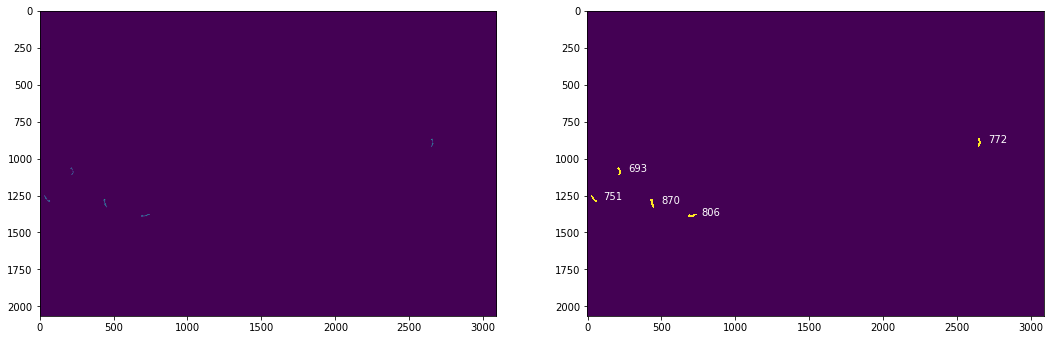

In [46]:
from skimage.measure import label, regionprops
t = 20
plt.figure(figsize=(18,16))
plt.subplot(121)
plt.imshow(rawframes[t])#+lawn)
plt.subplot(122)
plt.imshow(masks[t])#[1400:1600,300:600])#[500:1500,2000:3500])#[:,2500:])
label_image = label(masks[t], background=0, connectivity = 1)
for region in regionprops(label_image):
    print(region.slice)
    plt.text(region.centroid[1]+60, region.centroid[0], region.area, color ='w')

# Detecting individual objects and tracking or use multiprocessing to speed up feature detection

In [47]:
%%time
import time

nWorkers = 10
if nWorkers ==1:

    #masks = tracking.preprocess(rawframes, minSize = param['minSize'], threshold =None )
    print('Detecting features')
    features = tracking.runfeatureDetection(rawframes, masks, param, frameOffset = 0)
else:
    from multiprocessing import Pool
    print('Detecting features')
    def f(sl):
        a,b = sl
        if len(rawframes[a:b])>1:
            return tracking.runfeatureDetection(rawframes[a:b], masks[a:b], param, frameOffset = a)
    features = []
    L = len(rawframes)
    # create chunks of analysis based on how many workers we use
    print(L)
    chunksize = L//nWorkers//20
    #slices = np.arange(L)
    slices = zip((range(0,L, chunksize)), (range(chunksize,L+chunksize, chunksize)))
    
    p = Pool(processes = nWorkers)
    start = time.time()
    for k, res in enumerate(p.imap_unordered(f, slices)):
        features.append(res)
        if k == nWorkers:
            print('Expected time is approx. {} s'.format((L/chunksize-k)*(time.time()-start)/nWorkers/2))
        #print(p, time.time()-start)
    features = pd.concat(features)
    p.close()
    p.join()

Detecting features
500
Expected time is approx. 22.425278663635254 s
CPU times: user 552 ms, sys: 213 ms, total: 765 ms
Wall time: 33.8 s


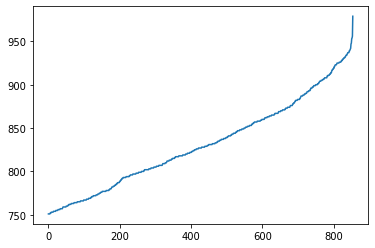

In [7]:

### Save the features
plt.plot(np.sort(features['area'].values))

In [51]:
features.head(5)
features.info(memory_usage='deep')
features.to_json(outfile.format('features', 'all'), orient='split')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19113 entries, 0 to 0
Data columns (total 9 columns):
area     19113 non-null int64
diffI    19113 non-null object
frame    19113 non-null int64
image    19113 non-null object
slice    19113 non-null object
x        19113 non-null float64
xw       19113 non-null float64
y        19113 non-null float64
yw       19113 non-null float64
dtypes: float64(4), int64(2), object(3)
memory usage: 5.7 MB


In [5]:
features = pd.read_json(outfile.format('features', 'all'), orient='split', numpy = True)

### Link objects to trajectories and interpolate short misses

In [48]:
print('Done')
print('Linking trajectories')
#trajectories = tracking.linkParticles(features, param['searchRange'], param['minimalDuration'])
#trajectories = tracking.linkParticles(features, 50, 500);
#trajectories = tp.link_df(features, 50, memory= 30)
#trajectories = tp.filter_stubs(trajectories,100)
pred = tp.predict.NearestVelocityPredict()
trajectories = pred.link_df(features, 10, memory= 30)

Frame 498: 3 trajectories present.


In [53]:
print('Interpolating trajectories')
traj = []
for particle_index in trajectories['particle'].unique():
    tmp = trajectories[trajectories.loc[:,'particle'] == particle_index]
    traj.append(tracking.interpolateTrajectories(tmp))
trajectories = pd.concat(traj)
trajectories['shapeX'] = trajectories['shapeX'].astype(int)
trajectories['shapeY'] = trajectories['shapeY'].astype(int)

Interpolating trajectories


In [10]:
print(trajectories['particle'].nunique())
trajectories = tp.filter_stubs(trajectories,600)
print(trajectories['particle'].nunique())

7
0


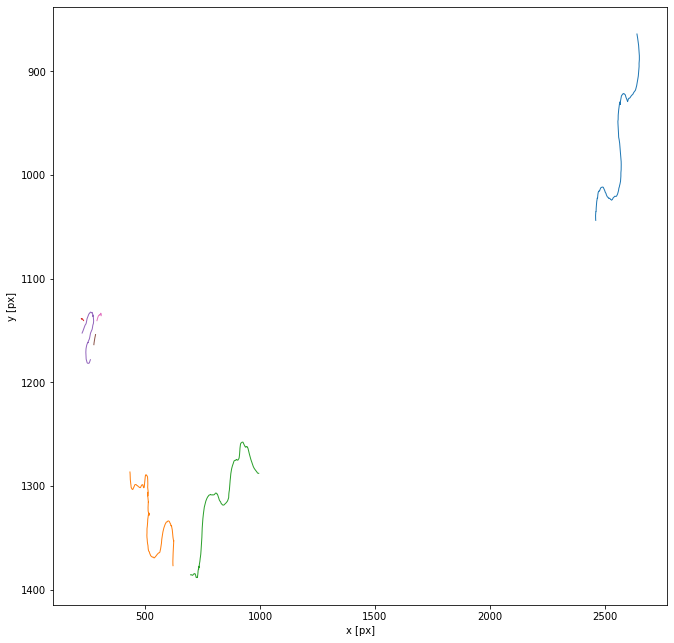

,frame,y,x,slice,area,image,yw,xw,diffI,shapeY,shapeX,particle
0,0,864.161039,2640.718182,"(slice(840, 889, None), slice(2618, 2667, None))",770.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...",863.544430,2640.661958,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",59,59,0.0
1,1,865.574109,2641.920629,NaN,775.0,NaN,864.890067,2641.766300,NaN,60,58,0.0
2,2,866.987179,2643.123077,"(slice(843, 894, None), slice(2620, 2667, None))",780.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",866.235704,2642.870642,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",61,57,0.0
3,3,868.279575,2643.773028,NaN,786.0,NaN,867.496085,2643.483193,NaN,62,56,0.0
4,4,869.571970,2644.422980,"(slice(844, 898, None), slice(2621, 2667, None))",792.0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",868.756466,2644.095744,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.00...",64,56,0.0


In [54]:
plt.figure(figsize=(11,11))
tp.plot_traj(trajectories)#, superimpose=1-masks[8000]);

### Save / Load trajectories if you need to have a checkpoint (fails if there are too many worms)

In [ ]:
trajectories.to_json(outfile.format('trajectories', 'all'), orient='split')

In [ ]:
trajectories = pd.read_json(outfile.format('trajectories', 'all'), orient='split', numpy = True)
trajectories['image'].replace('None', np.nan, inplace=True)

In [ ]:
trajectories['image'].replace([None], np.nan, inplace=True)

### add the missing images to interpolated trajectories

In [55]:
%%time
print('Fill in missing images')
from pharaglow import tracking, run, features
# interpolate the shape parameter

trajectories[['image']] = trajectories.apply(\
       lambda row: pd.Series(tracking.fillMissingImages(rawframes, row['frame'], row['x'], row['y'],\
                                               lengthX=row['shapeX'],lengthY=row['shapeY'], size=param['watershed'])) if np.all(np.isnan(row['image'])) else row['image'], axis=1)
trajectories[['diffI']] = trajectories.apply(\
        lambda row: pd.Series(tracking.fillMissingDifferenceImages(rawframes, row['frame'], row['x'], row['y'],\
                                                lengthX=row['shapeX'],lengthY=row['shapeY'], size=param['watershed'])) if np.all(np.isnan(row['diffI'])) else row['diffI'], axis=1)
trajectories[['diffI']] = trajectories.apply(\
        lambda row: pd.Series(tracking.fillMissingDifferenceImages(rawframes, row['frame'], row['x'], row['y'],\
                                                lengthX=row['shapeX'],lengthY=row['shapeY'], size=param['watershed'])) if np.sum((row['diffI']))==0 else row['diffI'], axis=1)

Fill in missing images
CPU times: user 27 s, sys: 16.2 s, total: 43.2 s
Wall time: 44.2 s


### Extract lawn info

In [11]:
%%time

def inside(x,y,binLawn):
    return binLawn[int(y), int(x)]

if lawnfile is not None:
    trajectories['inside'] = trajectories.apply(\
        lambda row: pd.Series(inside(row['x'], row['y'], binLawn)), axis=1)

CPU times: user 296 ms, sys: 4.3 ms, total: 300 ms
Wall time: 297 ms


### Show resulting trajectories

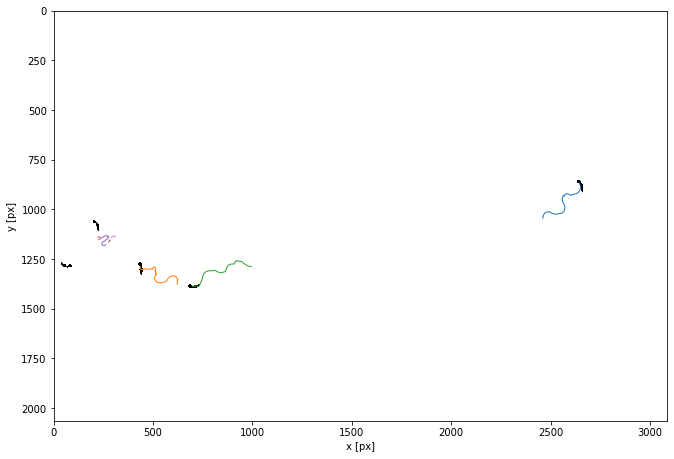

,frame,y,x,slice,area,image,yw,xw,diffI,shapeY,shapeX,particle
0,0,864.161039,2640.718182,"(slice(840, 889, None), slice(2618, 2667, None))",770.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...",863.544430,2640.661958,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",59,59,0.0
1,1,865.574109,2641.920629,NaN,775.0,0 0 1 0 2 0 3 0 4 ...,864.890067,2641.766300,0 0.0 1 0.0 2 0.0 3 0....,60,58,0.0
2,2,866.987179,2643.123077,"(slice(843, 894, None), slice(2620, 2667, None))",780.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",866.235704,2642.870642,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",61,57,0.0
3,3,868.279575,2643.773028,NaN,786.0,0 0 1 0 2 0 3 0 4 ...,867.496085,2643.483193,0 0.0 1 0.0 2 0.0 3 0....,62,56,0.0
4,4,869.571970,2644.422980,"(slice(844, 898, None), slice(2621, 2667, None))",792.0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",868.756466,2644.095744,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.00...",64,56,0.0


In [56]:
plt.figure(figsize=(11,11))
tp.plot_traj(trajectories, superimpose=1-masks[10]);

In [57]:
# # write trajectories to separate files.
#trajectories = pd.read_json(outfile.format('trajectories', 'all'), orient='split', numpy = True)
for particle_index in trajectories['particle'].unique():
    tmp = trajectories[trajectories.loc[:,'particle'] == particle_index]
    tmp.to_json(outfile.format('trajectories', int(particle_index)), orient='split')

### check slow-down before continuing analysis

In [ ]:
if lawnfile is not None:
    plt.figure(figsize=(12,8))
    vcut = []
    dt = 350
    for pid in trajectories['particle'].unique():
        tmp = trajectories[['frame', 'x', 'y']][trajectories.loc[:,'particle'] == pid].diff()
        f = (trajectories[['inside']][trajectories.loc[:,'particle'] == pid]).mean().values
        if f<0.9 and f>0.01:
            t0 = np.where((trajectories[['inside']][trajectories.loc[:,'particle'] == pid])==1)[0][0]
            if t0>dt:
                print(pid)
                time = np.linspace(0,2*dt/30., 2*dt)
                v = np.sqrt((tmp['x']**2+tmp['y']**2))/tmp['frame']*30*2.4
                plt.plot(time, v.iloc[t0-dt:t0+dt].values, 'navy', alpha=0.1)
                
                vcut.append(v.iloc[t0-dt:t0+dt].values)
    plt.plot(time, np.mean(np.array(vcut), axis=0), color='navy')
    plt.plot(time, util.smooth(np.mean(np.array(vcut), axis=0), 30), color='r')
    plt.axvline(dt/30, color='k', linestyle='--')
    plt.ylabel(r"velocity ($\mu$m/s)");
    plt.xlabel("time (s)");
    plt.ylim(0,150)


### run the whole pharaglow feature extraction

In [58]:
from multiprocessing import Pool
def parallelize_dataframe(df, func, params, n_cores):
    df_split = np.array_split(df, n_cores)
    print([len(d) for d in df_split])
    pool = Pool(n_cores)
    df = pd.concat(pool.starmap(func, zip(df_split, np.repeat(params, len(df_split)))))
    pool.close()
    pool.join()
    return df

#### run this if acidentally used an odd length like an idiot.

In [59]:
def padIm(im, size = 22500):
    return np.pad(im, (0,size-len(im)), mode='constant', constant_values=0)
def fixImages(trajectories):
    trajectories[['image']] = trajectories.apply(\
       lambda row: pd.Series(padIm(row['image'], row['shapeX']*row['shapeY'])) if len(row['image'])<row['shapeX']*row['shapeY'] else row['image'], axis=1)
    trajectories[['diffI']] = trajectories.apply(\
       lambda row: pd.Series(padIm(row['diffI'], row['shapeX']*row['shapeY'])) if len(row['diffI'])<row['shapeX']*row['shapeY'] else row['diffI'], axis=1)
    

### Save data as hdf5 format (every trajectory in a file)

In [60]:
%%time
import os
path = os.path.dirname(outfile)
for fn in os.listdir(path):
    file = os.path.join(path,fn)
    if os.path.isfile(file) and 'trajectories_' in fn and fn.endswith('.json'):
        particle_index = int(fn.split('.')[0].split('_')[-1])
        traj =  pd.read_json(file, orient='split', numpy = True)
        traj['shapeX'] = traj['shapeX'].astype(int)
        print('Analyzing trajectory:', fn)
        # interpolate if images are not the right size:
        fixImages(traj)
        tmp = parallelize_dataframe(traj, run.runPharaglowOnStack, n_cores = 2, params = param)
        tmp.to_json(outfile.format('results', particle_index), orient='split')
        

/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: the 'numpy' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'numpy'
  import sys


Analyzing trajectory: 20200319_NZ0040_trajectories_0.json
[249, 249]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/ut

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 75 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 76 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 88 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 121 fits in uint8
  return convert(image, np.uint8, force_copy)


Analyzing trajectory: 20200319_NZ0040_trajectories_1.json
[249, 249]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/ut

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 104 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 117 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: 20200319_NZ0040_trajectories_10.json
[8, 8]


/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 95 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 90 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 

Analyzing trajectory: 20200319_NZ0040_trajectories_11.json
[23, 23]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/ut

Analyzing trajectory: 20200319_NZ0040_trajectories_2.json
[249, 249]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/ut

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: 20200319_NZ0040_trajectories_3.json
[1, 0]


/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)


ValueError: Columns must be same length as key

In [61]:
data = pd.read_json(outfile.format('results', '0'), orient='split', numpy = True)


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'numpy' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'numpy'
  """Entry point for launching an IPython kernel.


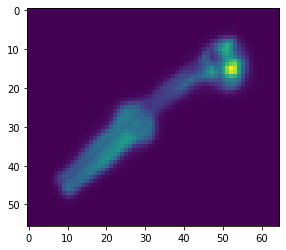

In [75]:
x0=450
plt.imshow(np.array(data.iloc[x0]['image']).reshape(data.iloc[x0]['shapeY'], -1))